In [9]:
import pandas
import pm4py

In [11]:
event_log = pandas.read_csv('TJSP-BL-event-log.csv', sep=',')
#lawsuit_id,date,movement,order,status,area,subject_matter,control,digital,class,distribution_date,court_department,claim_amount,judge
event_log = pm4py.format_dataframe(event_log, case_id='lawsuit_id', activity_key='movement', timestamp_key='date')
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
#print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))
# the log is filtered on the top 5 variants
filtered_log = pm4py.filter_variants_top_k(event_log , 5)

In [12]:
import time
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def retrieve_traces(log):
    traces, ids = [], []
    for id in log["case:concept:name"].unique():
        events = list(log[log["case:concept:name"] == id]["concept:name"])
        traces.append(["".join(x) for x in events])
        ids.append(id)

    return ids, traces

def run_doc2vec(config, log):
    ids, traces = retrieve_traces(log)

    start_time = time.time()

    tagged_traces = [TaggedDocument(words=act, tags=[str(i)]) for i, act in enumerate(traces)]

    # generate model
    model = Doc2Vec(vector_size=config["vector_size"], min_count=1, window=3, dm=1, workers=-1)
    model.build_vocab(tagged_traces)
    vectors = [model.infer_vector(trace) for trace in traces]

    end_time = time.time() - start_time
    print(f"\nDoc2vec took {round(end_time, 2)} seconds")

    # saving
    encoded_df = pd.DataFrame(vectors, columns=[f'{i}' for i in range(config["vector_size"])])
    encoded_df.insert(0, "case", ids)

    return encoded_df

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [3]:
# a directly - follows graph (DFG) is discovered from the log
dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log)


/Users/cadu/Documents/desenvolvimento/workspace/ml/my_env/lib/python3.12/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


In [4]:
# a process tree is discovered using the inductive miner
process_tree = pm4py.discover_process_tree_inductive(filtered_log)

In [5]:
# the process tree is converted to an accepting Petri net
petri_net , initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
process_tree = pm4py.discover_process_tree_inductive(filtered_log)

In [6]:
# the accepting Petri net is converted to a BPMN diagram
bpmn_diagram = pm4py.convert_to_bpmn(petri_net, initial_marking, final_marking)

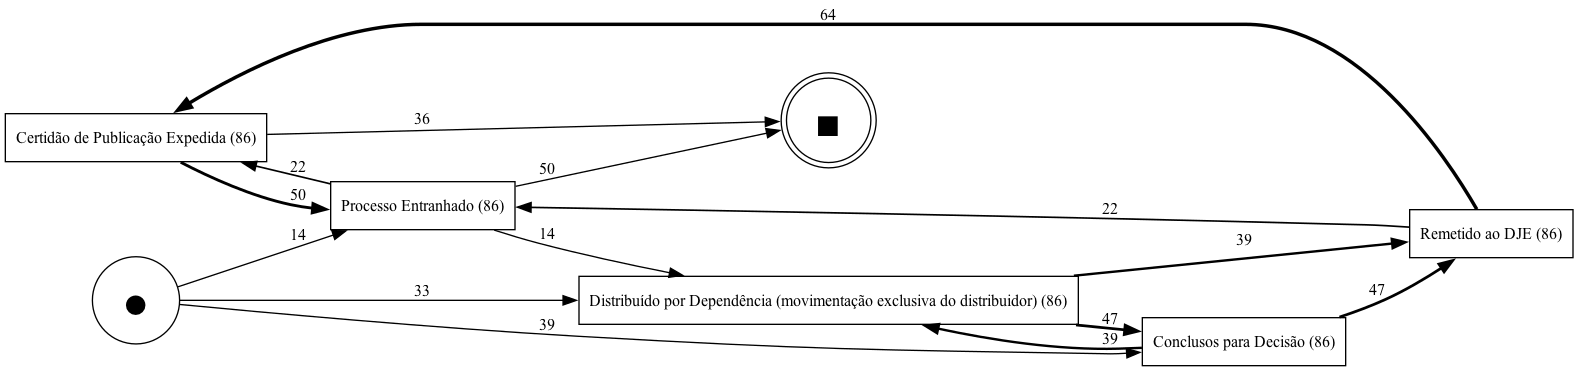

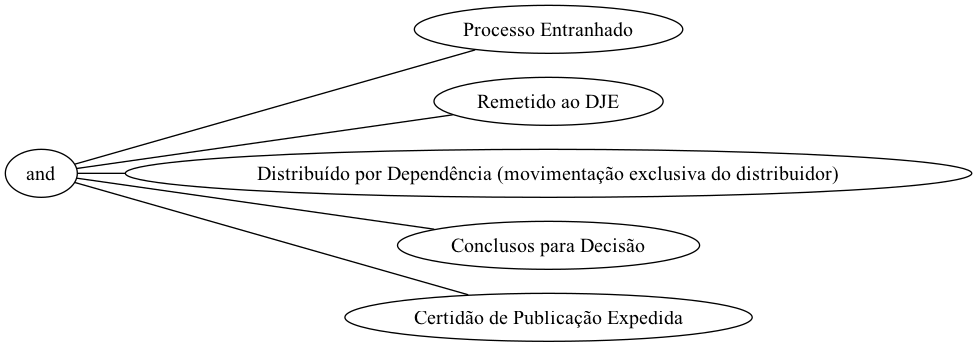

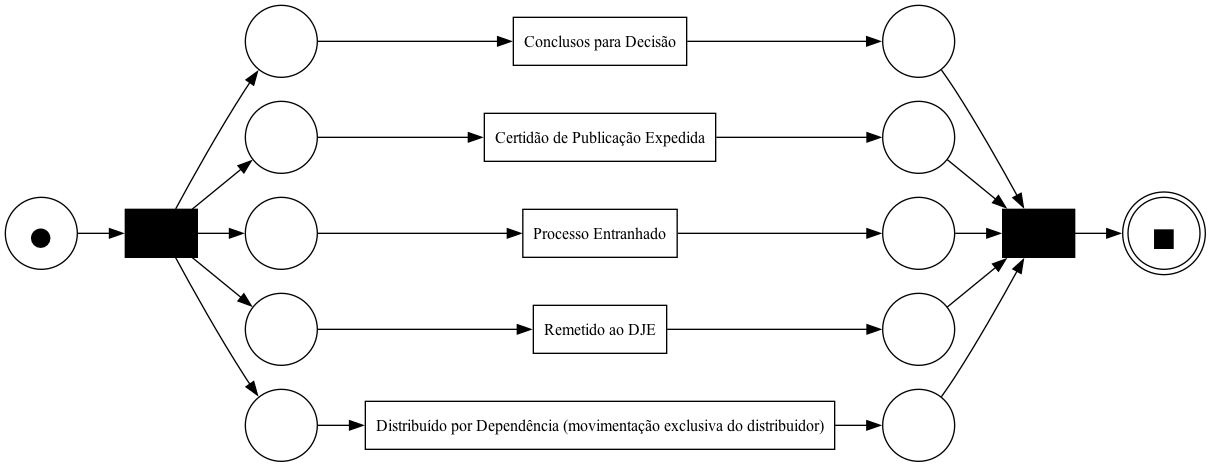

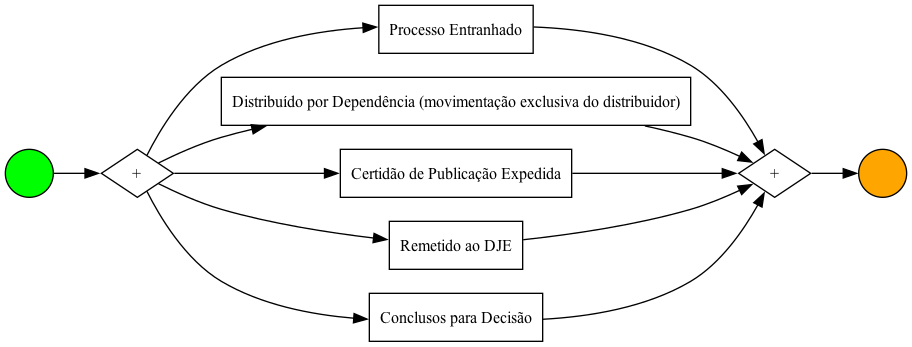

In [7]:
# the discovered process models are shown on the screen as .svg images
pm4py.view_dfg(dfg, start_activities, end_activities, format='png')
pm4py.view_process_tree(process_tree , format='png')
pm4py.view_petri_net(petri_net, initial_marking, final_marking, format='png')
pm4py.view_bpmn(bpmn_diagram, format='png')

In [8]:
# we compare the original log versus the discovered model
fitness = pm4py.fitness_token_based_replay(filtered_log, petri_net, initial_marking, final_marking)
precision = pm4py.precision_token_based_replay(filtered_log, petri_net, initial_marking, final_marking)
print(fitness) # 0.984
print(precision) # 0.758
# we check if the discovered model is a sound workflow net
is_sound_wfnet = pm4py.check_soundness(petri_net, initial_marking, final_marking)[0]
print(is_sound_wfnet) # True

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/14 [00:00<?, ?it/s]

{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
0.5667774086378737
True


/Users/cadu/Documents/desenvolvimento/workspace/ml/my_env/lib/python3.12/site-packages/pm4py/algo/analysis/woflan/place_invariants/utility.py:153: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn("solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.")
